# CNN with transfer learning

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os

In [63]:
from keras.models import Sequential, load_model 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
#from keras.utils import img_to_array, load_img
from keras.utils.vis_utils import plot_model
from glob import glob
from keras.callbacks import ModelCheckpoint
from keras import Model, Input
from keras import experimental

## Image loading and visualisation

In [3]:
train_path = "../Data/clean/output/train_b/"
test_path = "../Data/clean/output/test_b/"
val_path = "../Data/clean/output/val_b/"

In [5]:
root_dir = '../Data/clean'
classes = ['glass', 'organic', 'paper', 'recycling_point', 'yellow']
class_names_label = {classes:i for i, classes in enumerate(classes)}
display(class_names_label)
nb_classes = len(classes)

{'glass': 0, 'organic': 1, 'paper': 2, 'recycling_point': 3, 'yellow': 4}

In [9]:
def load_data(image_size = (160,160)):
    '''
    Load the data:
        - 9861 images to train the network.
        - 2466 images to evaluate how accurately the network learned to classify images.

    Output: tuples for train and test set (image, labels)
    '''
    
    datasets = [train_path, test_path, val_path]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [10]:
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

Loading ../Data/clean/output/train_b/


100%|██████████| 2157/2157 [00:04<00:00, 479.16it/s]


Loading ../Data/clean/output/test_b/


100%|██████████| 270/270 [00:00<00:00, 312.72it/s]


Loading ../Data/clean/output/val_b/


100%|██████████| 270/270 [00:00<00:00, 366.29it/s]


In [ ]:
def prepare_df(data_type):
    X = []
    y = []
    path = '../Data/clean/output/' + data_type + '/'

    for i in os.listdir(path):
        # Image
        X.append(i)
        # Label
        y.append(i.split('_')[0])

    X = np.array(X)
    y = np.array(y)

    df = pd.DataFrame()
    df['filename'] = X
    df['label'] = y

    return df


df_train = prepare_df('training')
df_val = prepare_df('validation')
df_test = prepare_df('evaluation')

### Plot data 

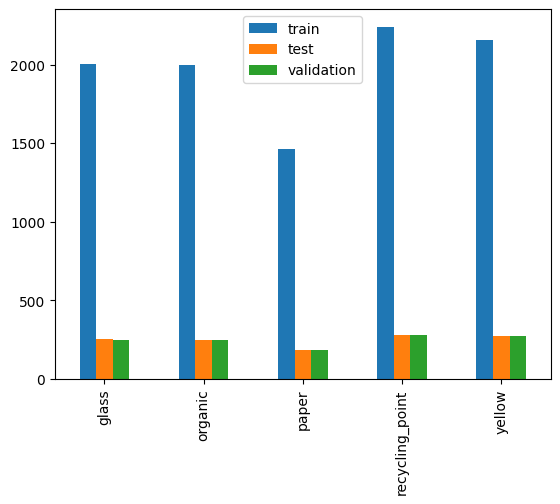

In [11]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
_, val_counts = np.unique(val_labels, return_counts=True)
data = pd.DataFrame({'train': train_counts,
                    'test': test_counts,
                    'validation': val_counts}, 
             index=classes
            )
data.plot.bar()
plt.show()

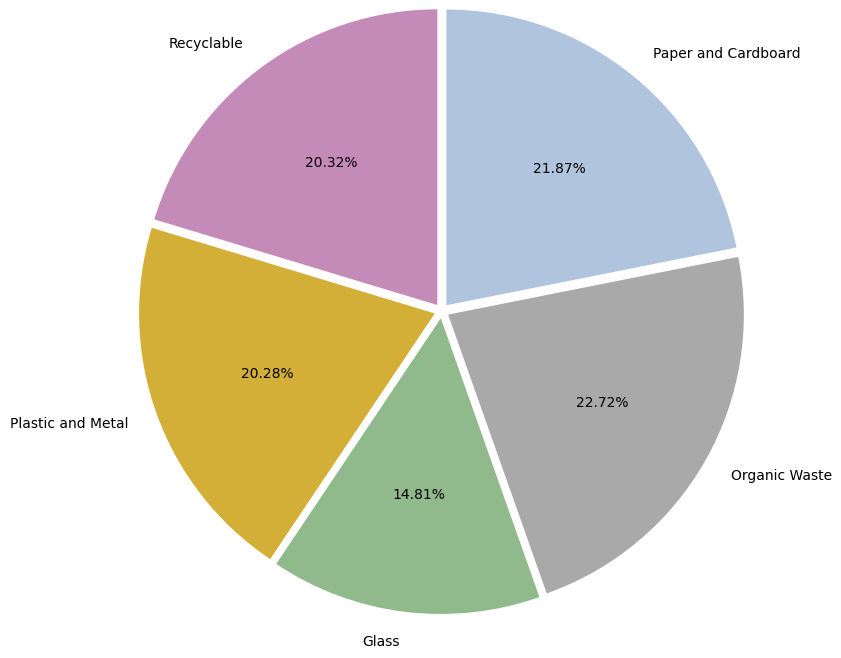

In [12]:
# plot the different categories
colors = ['#c48bb8','#D4AF37', '#90B98C', '#A9A9A9', '#B0C4DE']
plt.pie(train_counts,startangle=90,explode=[0.05,0.05, 0.05,0.05, 0.05],autopct='%0.2f%%',
        labels=['Recyclable', 'Plastic and Metal', 'Glass', 'Organic Waste', 'Paper and Cardboard'], colors= colors,radius=2)
plt.show()

In [14]:
train_images_b = train_images / 255.0 

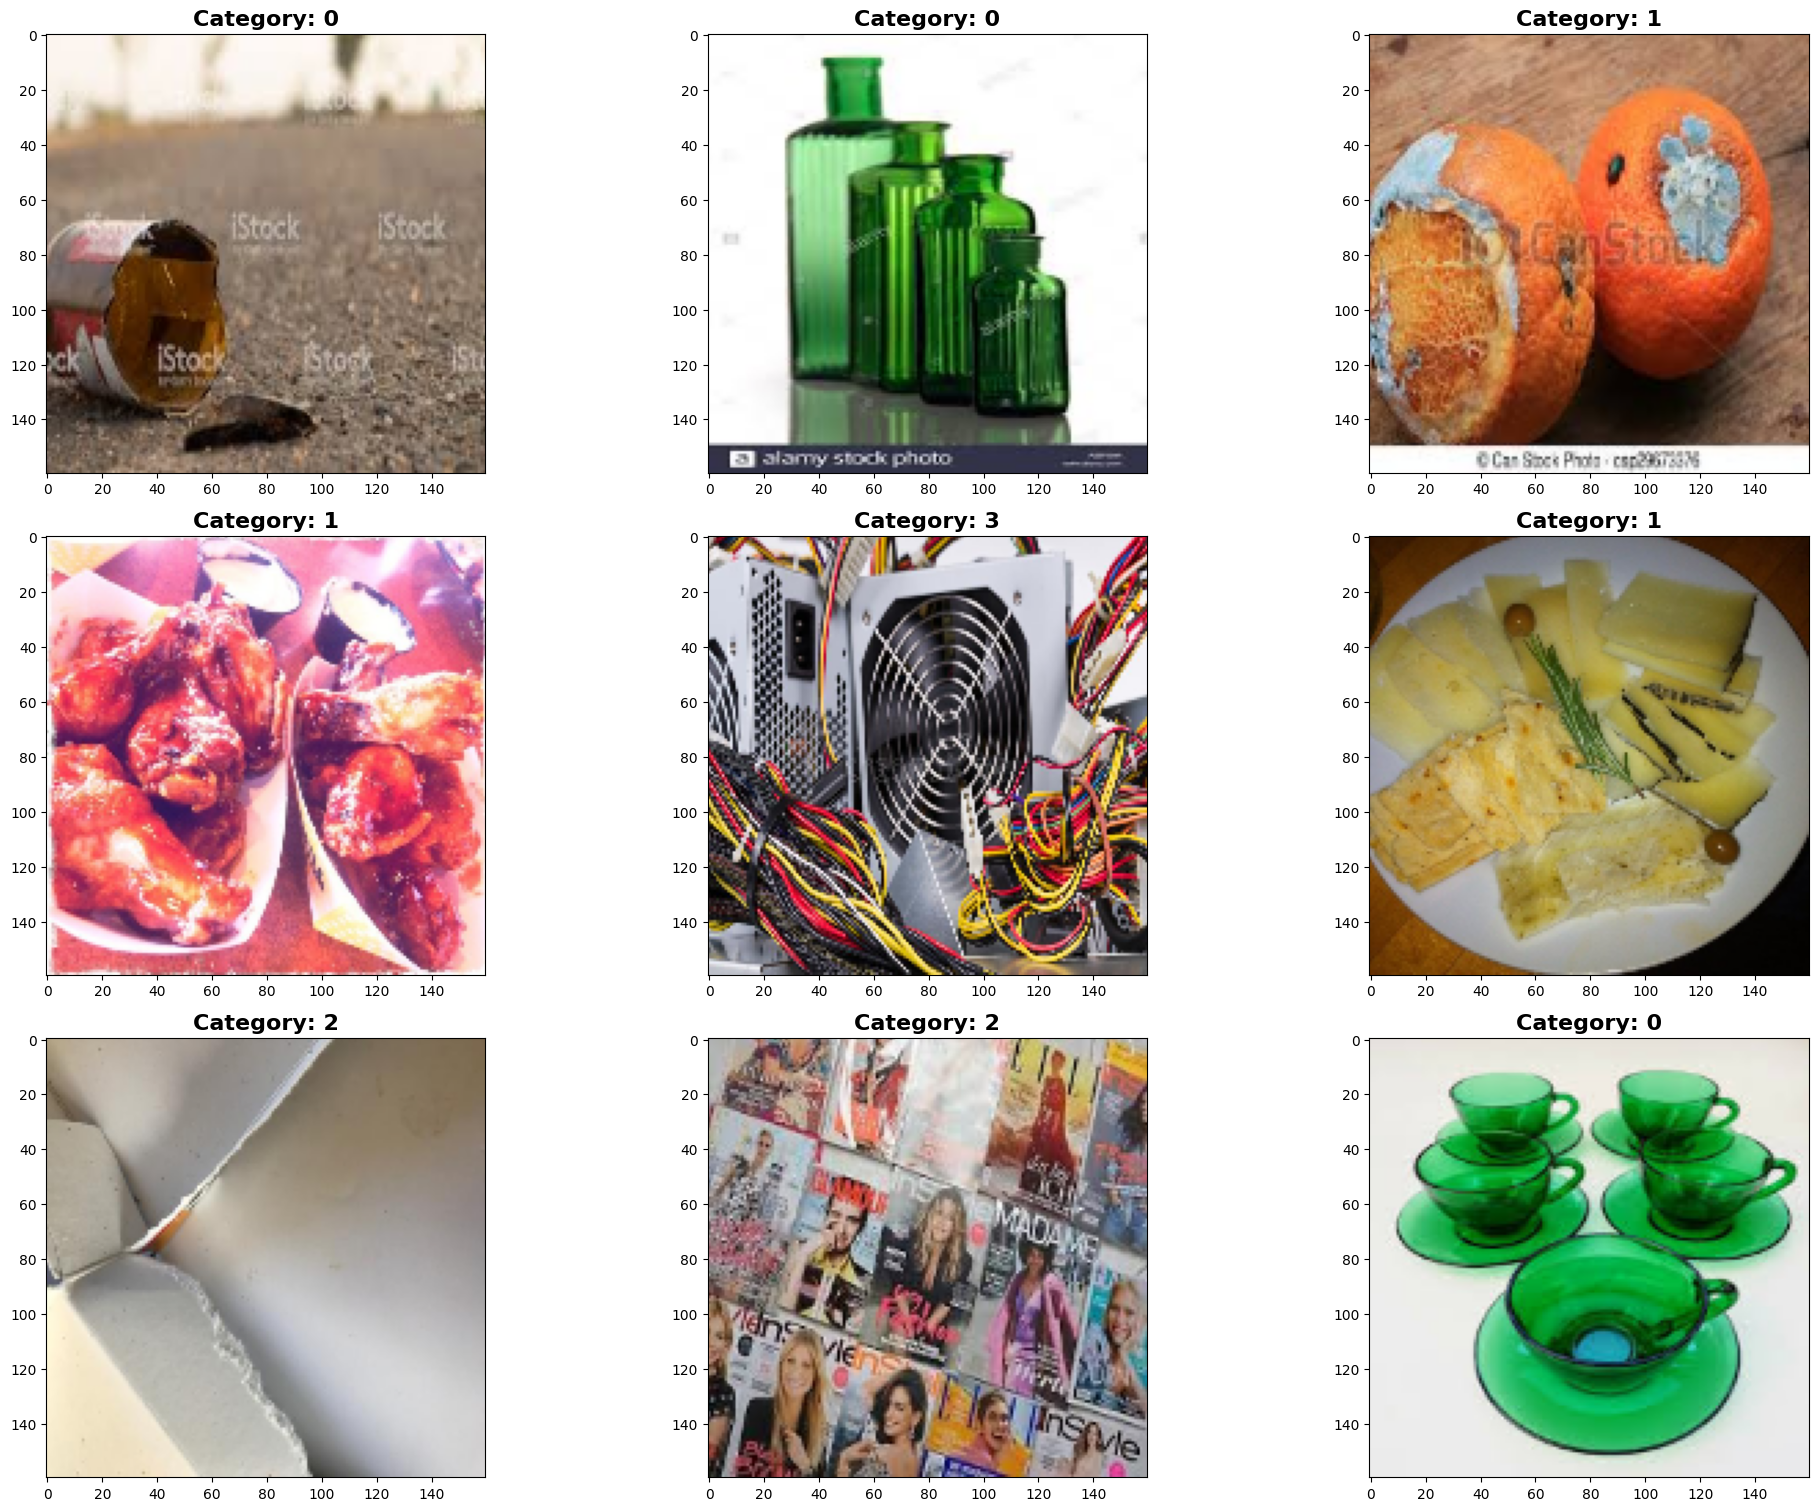

In [15]:
# the following plot gives us an idea of the type of images in the training set
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(9861)
    plt.title('Category: {0}'.format(train_labels[index]),fontdict={'size':16,'weight':'bold'})
    plt.imshow((train_images_b[index]*255).astype(np.uint8))
    plt.tight_layout()

## Model

In [16]:
from keras.applications import MobileNetV2, mobilenet_v2
from keras import Input

In [17]:
preprocess_input = mobilenet_v2.preprocess_input

In [8]:
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(160, 160, 3)

In [18]:
# load pre-trained model without "top" layers
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

9406464/9406464 [==============================] - 5s 1us/step


In [ ]:
#data_augmentation = tf.keras.Sequential([
 # tf.keras.layers.RandomFlip('horizontal'),
  #tf.keras.layers.RandomRotation(0.2),
#])

In [ ]:
preprocess_input = mobilenet_v2.preprocess_input
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [20]:
# freeze the layers in the pretrained model
base_model.trainable=False

In [67]:
plot_model(base_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [26]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(5, activation = 'softmax')

In [32]:
inputs = Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                    

In [ ]:
from keras.optimizers import Adam
OPTIMIZER = Adam(learning_rate=0.0001)

In [34]:
model.compile(loss = "sparse_categorical_crossentropy",
                optimizer = OPTIMIZER,
                metrics = ["accuracy"])

In [ ]:
def create_model(inputs):
    #inputs = Input(shape=(160,160,3))
    model = base_model(inputs, training = False)

    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu') )
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax')) # output

    model.compile(loss = "sparse_categorical_crossentropy",
                optimizer = OPTIMIZER,
                metrics = ["accuracy"])
    return model

In [ ]:
model.add(Flatten())
model.add(Dense(512, activation = 'relu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(64, activation = 'relu') )
#model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(5, activation = 'softmax')) # output

model.compile(loss = "sparse_categorical_crossentropy",
            optimizer = "adam",
            metrics = ["accuracy"])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_path = '../Checkpoints/class-nn6.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor = 'val_accuracy',
    save_freq='epoch',
    save_weights_only=False,
    verbose=1,
    save_best_only = True,
    mode = 'max'
)

es = EarlyStopping(monitor='val_accuracy', patience=10)

In [36]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [38]:
hist6 = model.fit(x = aug.flow(train_images, train_labels, batch_size=32),
                   validation_data=(val_images, val_labels),
                   steps_per_epoch=len(train_images)//32,
                   epochs=10,
                   callbacks=[es,checkpoint])

Epoch 1/10
308/308 [==============================] - ETA: 0s - loss: 1.0616 - accuracy: 0.5903
Epoch 1: val_accuracy improved from -inf to 0.76055, saving model to ../Checkpoints\class-nn6.hdf5
308/308 [==============================] - 148s 480ms/step - loss: 1.0616 - accuracy: 0.5903 - val_loss: 0.6752 - val_accuracy: 0.7606
Epoch 2/10
308/308 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.7414
Epoch 2: val_accuracy improved from 0.76055 to 0.81981, saving model to ../Checkpoints\class-nn6.hdf5
308/308 [==============================] - 137s 445ms/step - loss: 0.7065 - accuracy: 0.7414 - val_loss: 0.5079 - val_accuracy: 0.8198
Epoch 3/10
308/308 [==============================] - ETA: 0s - loss: 0.5750 - accuracy: 0.7879
Epoch 3: val_accuracy improved from 0.81981 to 0.84172, saving model to ../Checkpoints\class-nn6.hdf5
308/308 [==============================] - 140s 453ms/step - loss: 0.5750 - accuracy: 0.7879 - val_loss: 0.4312 - val_accuracy: 0.8417
Epoc

In [39]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train acc")
    plt.plot(history.history['val_accuracy'], label = "Validation acc")
    plt.title("Accuracy: train vs validation")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train loss")
    plt.plot(history.history['val_loss'], label = "Validation loss")
    plt.title("Loss: train vs validation")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

### Plot: accuracy and loss

Loss = Sparse Categorical Crossentropy

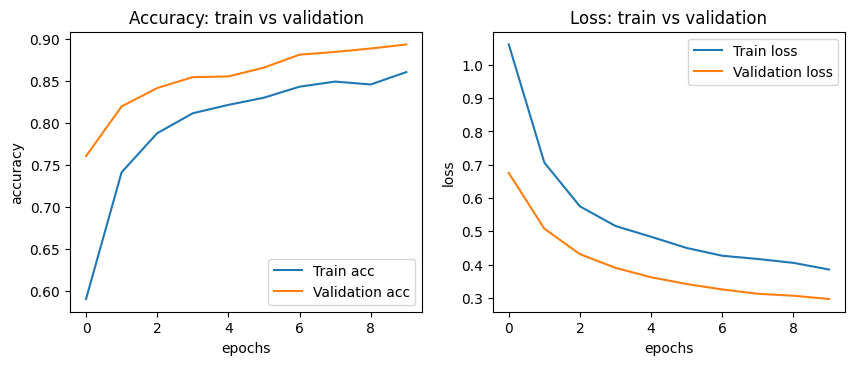

In [40]:
plot_accuracy_loss(hist6)

In [42]:
predictions6 = model.predict(test_images)     # Vector of probabilities
pred_labels6 = np.argmax(predictions6, axis = 1) # We take the highest probability

39/39 [==============================] - 13s 313ms/step


### Predictions

In [85]:
def display_random_image(class_names, images, labels):
    '''
    Display a random image from the images array and its correspond label from the labels array.
    Input: class_names, images, labels
    Output: labelled random image
    
    '''
    images = images/255
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow((images[index]*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

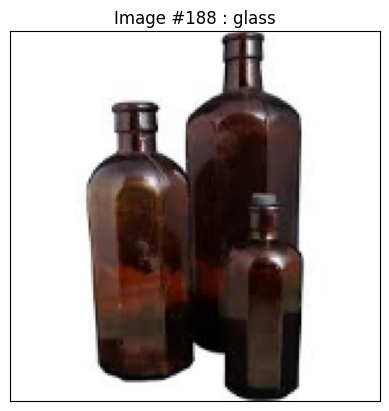

In [89]:
display_random_image(classes, test_images, pred_labels6)

## Model (more epochs)

In [48]:
checkpoint_path = '../Checkpoints/class-nn7.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor = 'val_accuracy',
    save_freq='epoch',
    save_weights_only=False,
    verbose=1,
    save_best_only = True,
    mode = 'max'
)

In [49]:
hist7 = model.fit(x = aug.flow(train_images, train_labels, batch_size=32),
                   validation_data=(val_images, val_labels),
                   steps_per_epoch=len(train_images)//32,
                   epochs=25,
                   callbacks=[es,checkpoint])

Epoch 1/25
308/308 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8638
Epoch 1: val_accuracy improved from -inf to 0.89042, saving model to ../Checkpoints\class-nn7.hdf5
308/308 [==============================] - 139s 451ms/step - loss: 0.3724 - accuracy: 0.8638 - val_loss: 0.2904 - val_accuracy: 0.8904
Epoch 2/25
308/308 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8650
Epoch 2: val_accuracy improved from 0.89042 to 0.89529, saving model to ../Checkpoints\class-nn7.hdf5
308/308 [==============================] - 146s 473ms/step - loss: 0.3627 - accuracy: 0.8650 - val_loss: 0.2833 - val_accuracy: 0.8953
Epoch 3/25
308/308 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8650
Epoch 3: val_accuracy improved from 0.89529 to 0.89692, saving model to ../Checkpoints\class-nn7.hdf5
308/308 [==============================] - 159s 515ms/step - loss: 0.3610 - accuracy: 0.8650 - val_loss: 0.2802 - val_accuracy: 0.8969
Epoc

### Plot: accuracy and loss

Loss = Sparse Categorical Crossentropy

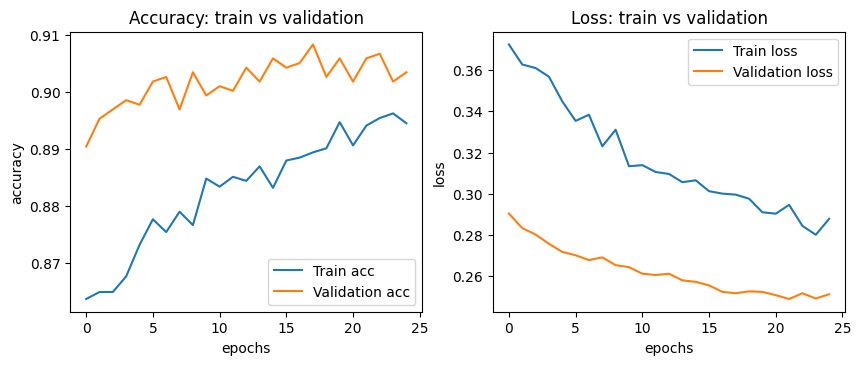

In [50]:
plot_accuracy_loss(hist7)

In [77]:
test_images_scaled.shape

(1234, 160, 160, 3)

### Predictions

In [51]:
predictions7 = model.predict(test_images)     # Vector of probabilities
pred_labels7 = np.argmax(predictions7, axis = 1) # We take the highest probability

39/39 [==============================] - 13s 339ms/step


In [80]:
predictions7

array([[9.9069703e-01, 8.8655303e-05, 7.9747508e-05, 6.8181027e-05,
        9.0663927e-03],
       [6.2396002e-01, 9.3268463e-03, 7.8420917e-04, 7.3275007e-03,
        3.5860145e-01],
       [9.8720771e-01, 2.2759031e-04, 7.8272307e-04, 1.0685881e-03,
        1.0713417e-02],
       ...,
       [3.8975697e-02, 5.1810085e-03, 4.9630931e-01, 1.2869620e-03,
        4.5824707e-01],
       [3.0577689e-01, 2.3790385e-04, 4.7475722e-04, 2.2458562e-04,
        6.9328588e-01],
       [1.4838867e-01, 6.8634413e-03, 1.8171869e-04, 2.1109931e-04,
        8.4435505e-01]], dtype=float32)

In [81]:
pred_labels7

array([0, 0, 0, ..., 2, 4, 4], dtype=int64)

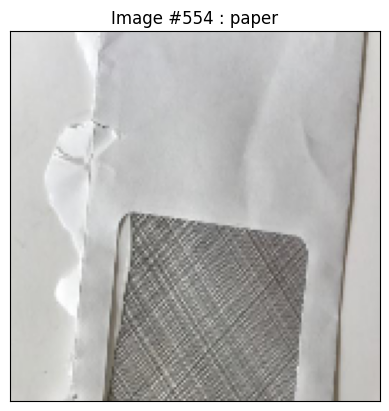

In [73]:
display_random_image(classes, test_images_scaled, pred_labels7)

### Save model

In [62]:
model.save('../Models/cnn_mobilnet.h5')

In [64]:
new_model = load_model('../Models/cnn_mobilnet.h5')

In [65]:
new_predictions = new_model.predict(test_images)
np.testing.assert_allclose(predictions7, new_predictions, rtol=1e-6, atol=1e-6) # Raises an AssertionError if two objects are not equal up to desired tolerance

39/39 [==============================] - 13s 310ms/step


In [78]:
pred_labels_new = np.argmax(new_predictions, axis = 1)

In [ ]:
predictions7 = model.predict(test_images)     # Vector of probabilities
pred_labels7 = np.argmax(predictions7, axis = 1) # We take the highest probability

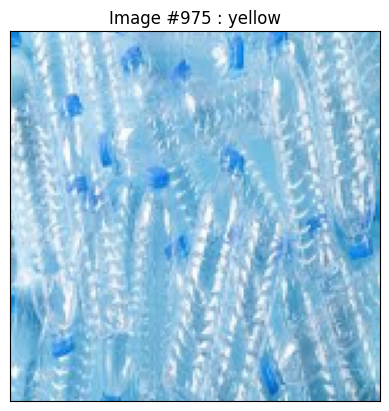

In [79]:
display_random_image(classes, test_images_scaled, pred_labels_new)

### Export model

In [69]:
# Exportar el modelo a 'SavedModel'
#experimental.export_saved_model(model, '../Models/test.h5')

# Recrea exactamente el mismo modelo
#new_model = keras.experimental.load_from_saved_model('path_to_saved_model')

# Verifique que el estado esté guardado
#new_predictions = new_model.predict(x_test)
#np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Tenga en cuenta que el estado del optimizador también se conserva:
# puede reanudar el entrenamiento donde lo dejó.